In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg
/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg
/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg
/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg
/kaggle/input/dog-breed-identification/test/06ecb29a374579fb320c1c7d2801cbe1.jp

In [2]:
import tensorflow as tf
print("TF version",tf.__version__)

2024-02-27 16:08:37.477032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 16:08:37.477129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 16:08:37.632198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version 2.15.0


In [3]:
import tensorflow_hub as hub 
print("TF HUB version", hub.__version__)

TF HUB version 0.15.0


In [4]:
# Check GPU avaibility
print("GPU","availabele (YESSSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU availabele (YESSSS!!!!!!)


In [5]:
labels_csv = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

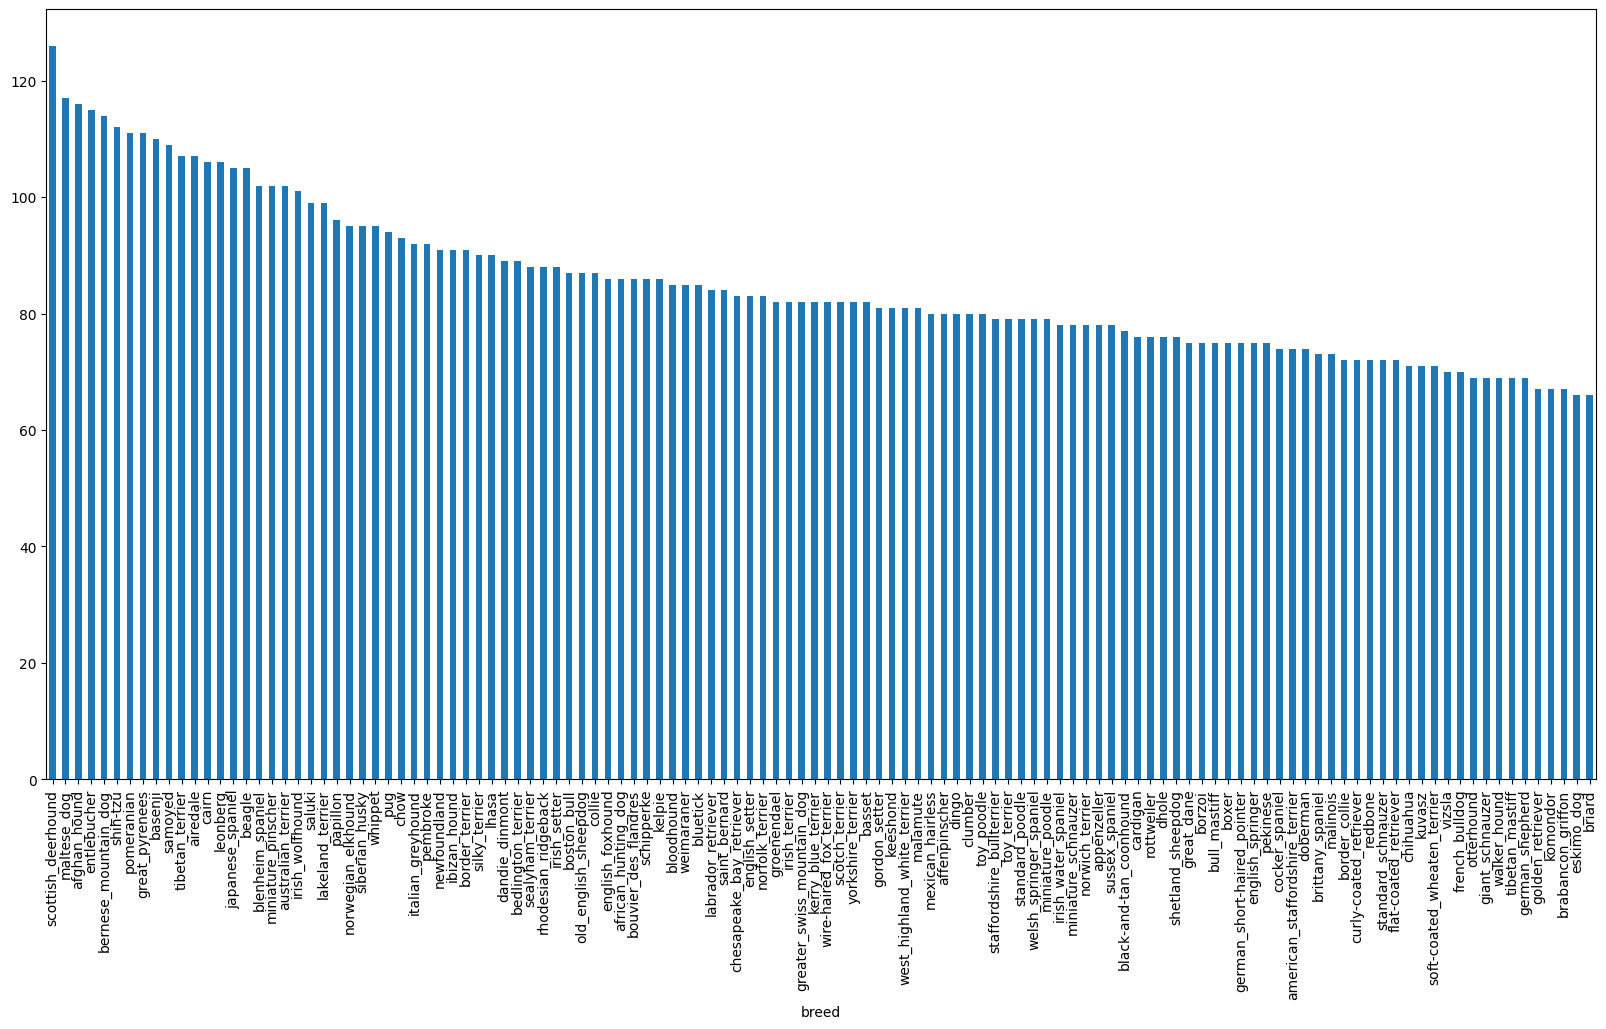

In [7]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [8]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

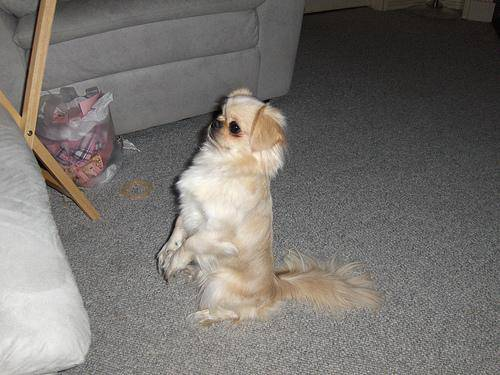

In [9]:
# Let's view an image
from IPython.display import Image
Image("/kaggle/input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg")

### Getting Images and Their labels Ready
Let's get a list of all of our image file pathnames.

In [10]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
# Create path names for image id's
filenames=["/kaggle/input/dog-breed-identification/train/"+fname +".jpg" for fname in labels_csv["id"]]

filenames[:10]

['/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/kaggle/input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/kaggle/input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/kaggle/input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/kaggle/input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/kaggle/input/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/kaggle/input/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/kaggle/input/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/kaggle/input/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/kaggle/input/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/kaggle/input/dog-breed-identification/train"))==len(filenames):
    print("Filenames match actual amount of files!!! Proceed")
else:
    print("bruhh")

Filenames match actual amount of files!!! Proceed


# Let's prepare labels

In [13]:
labels=labels_csv["breed"]
labels=np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
if len(labels)==len(filenames):
    print("matched")
else:
    print("Bruhh!!")

matched


In [16]:
# Find Unique Breeds
Unique_breeds=np.unique(labels)
Unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
len(Unique_breeds)

120

In [18]:
#Turn a single label into boolean array
print(labels[0])
labels[0]==Unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn 
boolean_labels=[label == Unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(Unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating Validation Set

In [22]:
X=filenames
y=boolean_labels

In [23]:
len(X)

10222

In [24]:
NUM_IMAGES= 1000 #@param (type:"slider",min:1000,max:10000,step:1000)

In [25]:
from sklearn.model_selection import train_test_split
# split the data 
X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                            y[:NUM_IMAGES],
                                            test_size=0.2,
                                            random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [26]:

# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['/kaggle/input/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/kaggle/input/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/kaggle/input/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/kaggle/input/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/kaggle/input/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fa

# Preprocessing Images(turning Images to Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

In [27]:
# convert image to numpy
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [29]:
# turns image into tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [30]:
# Define image size
IMG_SIZE=224

# Create a function for preprocessing image
def process_img(image_path):
    """
    Takes an image path anf turns into tensor flow
    """
#     Read the image file
    image=tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 color channels
    image=tf.image.decode_jpeg(image,channels=3)
    #convert the colour channel values from 0-255 to 0-1 values
    image=tf.image.convert_image_dtype(image,tf.float32)
    # Resize image 
    image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
    
    return image

# Turning out data into Batches

In [31]:
def get_image_label(image_path,label):
    image=process_img(image_path)
    return image,label

In [32]:
# Define the batch size
BATCH_SIZE=32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    if test_data:
        print("creating test data betches...")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch=data.map(process_img).batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        print("Creating Batches...")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating Batches...")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data=data.shuffle(buffer_size=len(X))
        data=data.map(get_image_label)
        data_batch=data.batch(BATCH_SIZE)
        
    return data_batch

In [33]:
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating Batches...
Creating Batches...


In [34]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [35]:
## Visualizing data batches
import matplotlib.pyplot as plt

# Cretate a function for viewing images in a data batch
def show_25_images(images,labels):
    plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image 
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(Unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")

In [36]:

train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

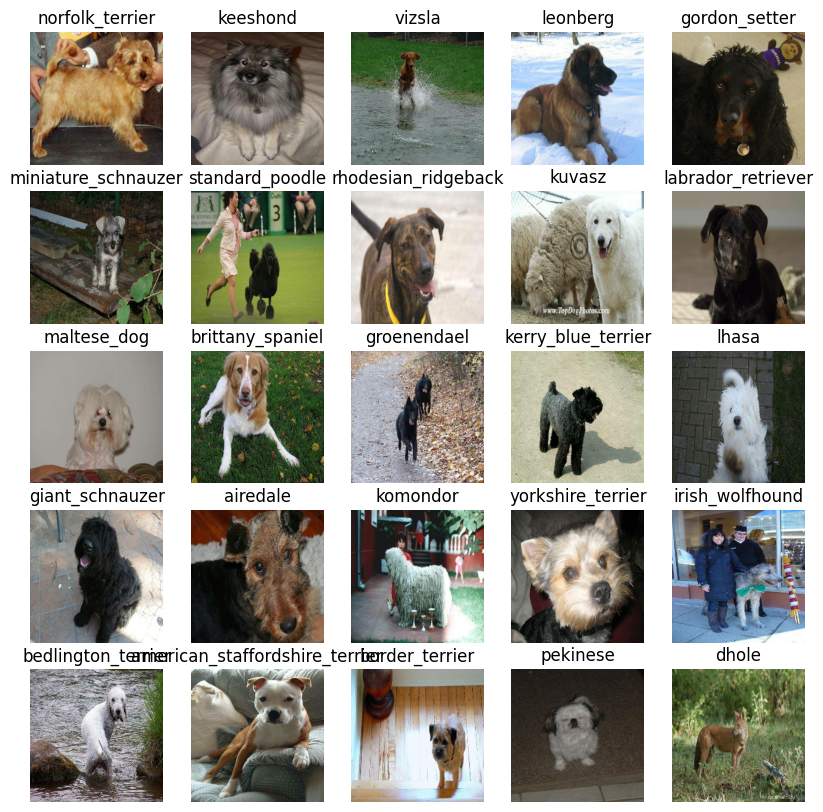

In [37]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

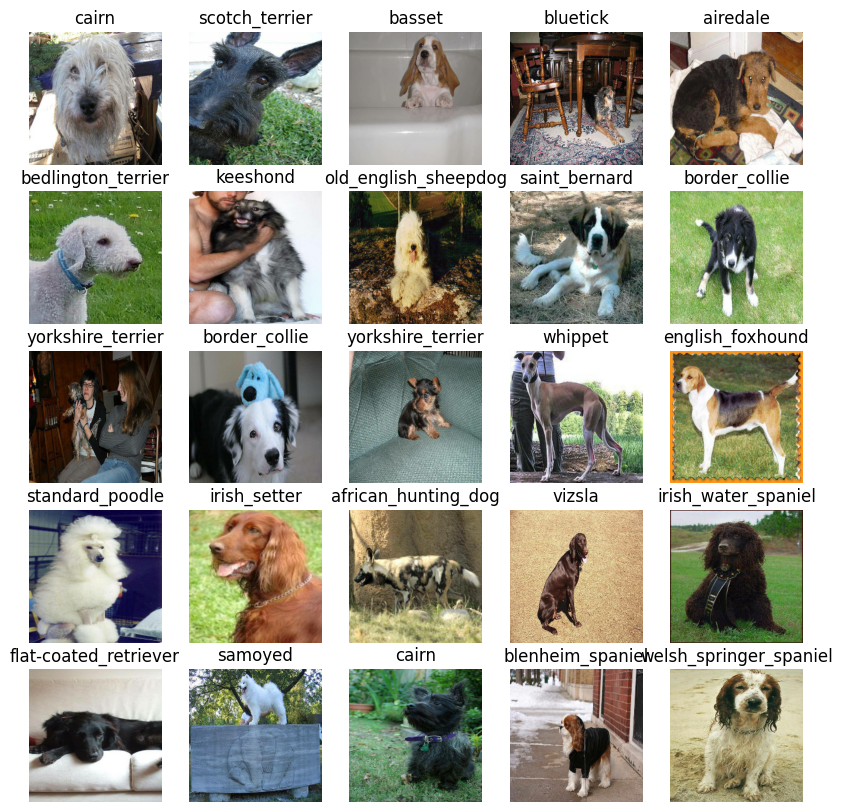

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Building the Model

In [39]:
IMG_SIZE

224

In [40]:
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE=len(Unique_breeds)

Model_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

- Takes the input shape, output shape and the model we've chosen as parameters.
- Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
- Compiles the model (says it should be evaluated and improved).
- Builds the model (tells the model the input shape it'll be getting).
- Returns the model.

In [41]:
# create the function which builds keras model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=Model_URL):
    print("Building model with :",Model_URL)
    
    model=tf.keras.Sequential([
            hub.KerasLayer(Model_URL),
            tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                    activation="softmax")
    ])
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
#     Build the model
    model.build(INPUT_SHAPE)
    
    return model

In [42]:
model=create_model()
model.summary()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.


We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

## TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. ✅
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [43]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [44]:
import datetime

def create_tensorboard_callback():
    logdir=os.path.join("/kaggle/working/",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
                       
    return tf.keras.callbacks.TensorBoard(logdir)

## Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [45]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=3)

## Training the model

In [46]:
NUM_EPOCHS=100 #@param {type:"slider,min:10,max:100,step:10"}

In [47]:
def train_model():
    model=create_model()
    
    tensorboard=create_tensorboard_callback()
    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=val_data,
             validation_freq=1,
             callbacks=[tensorboard,early_stopping])
    return model

In [48]:
model=train_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100


I0000 00:00:1709050150.107532     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 10s 149ms/step - loss: 4.7151 - accuracy: 0.0938 - val_loss: 3.3471 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 1s 58ms/step - loss: 1.7370 - accuracy: 0.6637 - val_loss: 2.0688 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 1s 58ms/step - loss: 0.5956 - accuracy: 0.9325 - val_loss: 1.5993 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 0.2623 - accuracy: 0.9875 - val_loss: 1.4217 - val_accuracy: 0.6650
Epoch 5/100
25/25 [==============================] - 1s 58ms/step - loss: 0.1509 - accuracy: 0.9975 - val_loss: 1.3484 - val_accuracy: 0.6800
Epoch 6/100
25/25 [==============================] - 1s 57ms/step - loss: 0.1035 - accuracy: 0.9987 - val_loss: 1.3093 - val_accuracy: 0.6700
Epoch 7/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 1.2845 - val_accuracy: 0.6800
Epoch 8/100
25/2

## Evaluating performance using TensorBoard logs

In [49]:
%tensorboard --logdir /kaggle/working/

## Making and evaluating prediction using a trained model

In [50]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [51]:
preds=model.predict(val_data,verbose=1)
preds

7/7 [==============================] - 1s 49ms/step


array([[1.6522026e-03, 6.1475788e-05, 1.8333436e-03, ..., 1.0743184e-04,
        1.5364991e-05, 1.8104912e-03],
       [6.6528120e-03, 7.1885664e-04, 2.2189948e-03, ..., 2.6166101e-04,
        9.1814308e-04, 1.6071807e-04],
       [3.0204454e-05, 3.8717708e-04, 3.4680437e-05, ..., 1.1642201e-05,
        1.7083657e-05, 5.9446559e-04],
       ...,
       [2.5137844e-05, 4.7909870e-04, 3.3313609e-05, ..., 6.4183536e-05,
        7.6325312e-05, 1.5586466e-04],
       [1.2854837e-02, 4.7228907e-05, 9.7876342e-05, ..., 6.6035231e-05,
        3.2659053e-05, 1.1235944e-02],
       [8.7468332e-05, 1.3447300e-05, 6.4357353e-04, ..., 1.8567676e-03,
        1.0059635e-03, 6.0540067e-05]], dtype=float32)

In [52]:
preds.shape

(200, 120)

In [53]:
np.sum(preds[0])

1.0000001

In [54]:
print(preds[0])
print(np.max(preds[0]))

[1.65220257e-03 6.14757882e-05 1.83334365e-03 1.79595372e-05
 1.72848086e-04 1.44344031e-05 1.22186430e-01 4.26789094e-03
 4.47899627e-04 2.80409091e-04 4.86279205e-05 3.31651419e-04
 5.11733291e-04 7.94330044e-05 6.25382643e-04 2.82687251e-04
 3.01843917e-04 4.51642722e-01 3.71291899e-05 1.03152961e-04
 7.45497702e-04 8.89380899e-05 3.39333892e-05 2.80529354e-03
 4.48876926e-05 1.11059227e-04 1.39863968e-01 8.77335042e-05
 1.65555422e-04 2.67917960e-04 2.23710813e-04 8.78067920e-04
 9.07982117e-04 9.81961239e-06 8.11816353e-05 6.55031158e-03
 1.96682367e-06 1.08386441e-04 4.41262266e-04 1.96965902e-05
 3.07767768e-04 2.12516443e-05 4.77015637e-05 1.44327860e-04
 1.16156996e-04 7.32562839e-05 2.77964955e-05 6.67512577e-05
 1.59128234e-04 9.42014594e-05 1.29532185e-04 1.14361806e-04
 2.45314674e-04 6.21301369e-05 8.97488062e-05 1.69573377e-05
 2.00200506e-04 1.08395691e-03 1.72025757e-03 6.21911995e-02
 2.22786271e-04 6.25771863e-05 3.07418260e-04 9.85878796e-06
 1.52350287e-03 6.133311

In [55]:
index = 42
print(preds[index])
print(f"Max value (probability of prediction): {np.max(preds[index])}")
print(f"Sum: {np.sum(preds[index])}")
print(f"Max index: {np.argmax(preds[index])}")
print(f"Predicted label: {Unique_breeds[np.argmax(preds[index])]}")

[6.85798150e-05 3.95677693e-04 6.57509154e-05 3.35150806e-04
 4.42849658e-03 2.76636827e-04 1.38000614e-04 1.92825124e-03
 8.94292630e-03 2.55749915e-02 3.08873568e-05 4.47947641e-05
 5.99094725e-04 3.94296786e-03 1.35309878e-03 6.98640430e-03
 6.86750500e-05 2.74823717e-04 2.06914265e-04 2.40671361e-04
 6.88427172e-05 8.13503982e-04 6.01796637e-05 1.23841630e-04
 1.05492966e-02 7.84357253e-05 1.51130866e-04 1.32573463e-04
 2.73702433e-04 8.38918786e-05 3.02975881e-04 2.18238230e-04
 1.62760218e-04 5.75860540e-05 4.49601321e-05 3.97570257e-05
 3.28208727e-04 1.74134126e-04 2.74864899e-04 1.35034412e-01
 1.18018586e-04 1.51508448e-05 4.51349001e-03 2.05908855e-05
 2.86485156e-04 1.60504878e-05 3.60842008e-04 1.91870771e-04
 7.40531032e-05 3.18509818e-04 2.07727062e-04 1.56976574e-04
 3.44964181e-04 8.37968080e-04 8.13665247e-06 5.46007068e-04
 3.32769763e-04 1.58689800e-04 1.03445840e-04 2.60050274e-05
 8.93633580e-04 5.23862953e-04 3.31051415e-05 7.83951109e-05
 3.74650117e-04 6.514417

In [56]:
def get_pred_label(preds_probabilities):
    return Unique_breeds[np.argmax(preds_probabilities)]

pred_label=get_pred_label(preds[81])
pred_label

'dingo'

# Unbatch the batches images

In [57]:
images_=[]
labels_=[]

for image,label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)
    
images_[0],labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [77]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
    of images and labels.
    """
    images = []
    labels = []
      # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(Unique_breeds[np.argmax(label)])
        
    return images, labels

    


In [78]:
val_images,val_labels=unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:

- Prediction labels
- Validation labels (truth labels)
- Validation images
- Let's make some function to make these all a bit more visaulize.

We'll create a function which:

- Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
- Convert the prediction probabilities to a predicted label. ✅
Plot the predicted label, its predicted probability, the truth label and the target 
- image on a single plot. ✅

In [87]:
def plot_pred(prediction_prob,labels,images,n=1):
    pred_prob,true_label,image=prediction_prob[n],labels[n],images[n]
    
    pred_label=get_pred_label(pred_prob)
    #plot imager & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # change the colour
    if pred_label==true_label:
        color="green"
    else:
        color="red"
    #change plot title
    
    plt.title("{}{:2.0f}%{}".format(pred_label,np.max(pred_prob)*100, true_label,color=color))
    

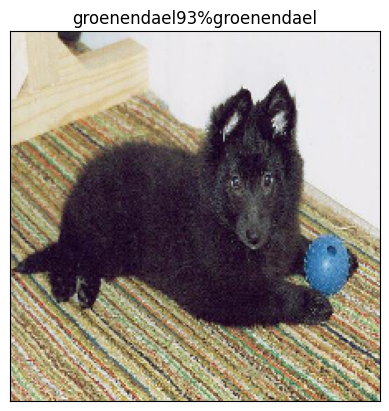

In [89]:
plot_pred(prediction_prob=preds ,labels=val_labels,images=val_images,n=77)

# Top 10 predictions

In [101]:
def plot_pred_conf(prediction_probs,labels,n=1):
    pred_prob,true_label=prediction_probs[n],labels[n]
    # get the predicted label
    pred_label=get_pred_label(pred_prob)
    
    # find top 10 predictions
    top_10_indexes=pred_prob.argsort()[-10:][::-1]
    # top 10 pred values
    top_10_values=pred_prob[top_10_indexes]
    
    # top 10 labels
    top_10_labels=Unique_breeds[top_10_indexes]
    
    # setup plot
    top_plot=plt.bar(np.arange(len(top_10_labels)),top_10_values,color="grey")
    
    plt.xticks(np.arange(len(top_10_labels)),
              labels=top_10_labels,
              rotation="vertical")
    if np.isin(true_label, top_10_labels):
        top_plot[np.argmax(top_10_labels == true_label)].set_color("green")
    else:
        pass
    

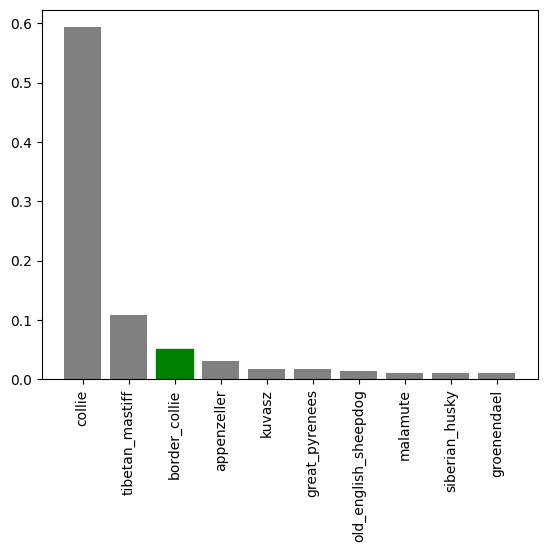

In [102]:
plot_pred_conf(prediction_probs=preds,
               labels=val_labels,
               n=9)

# functions to evaluate predictions and evvaluate model

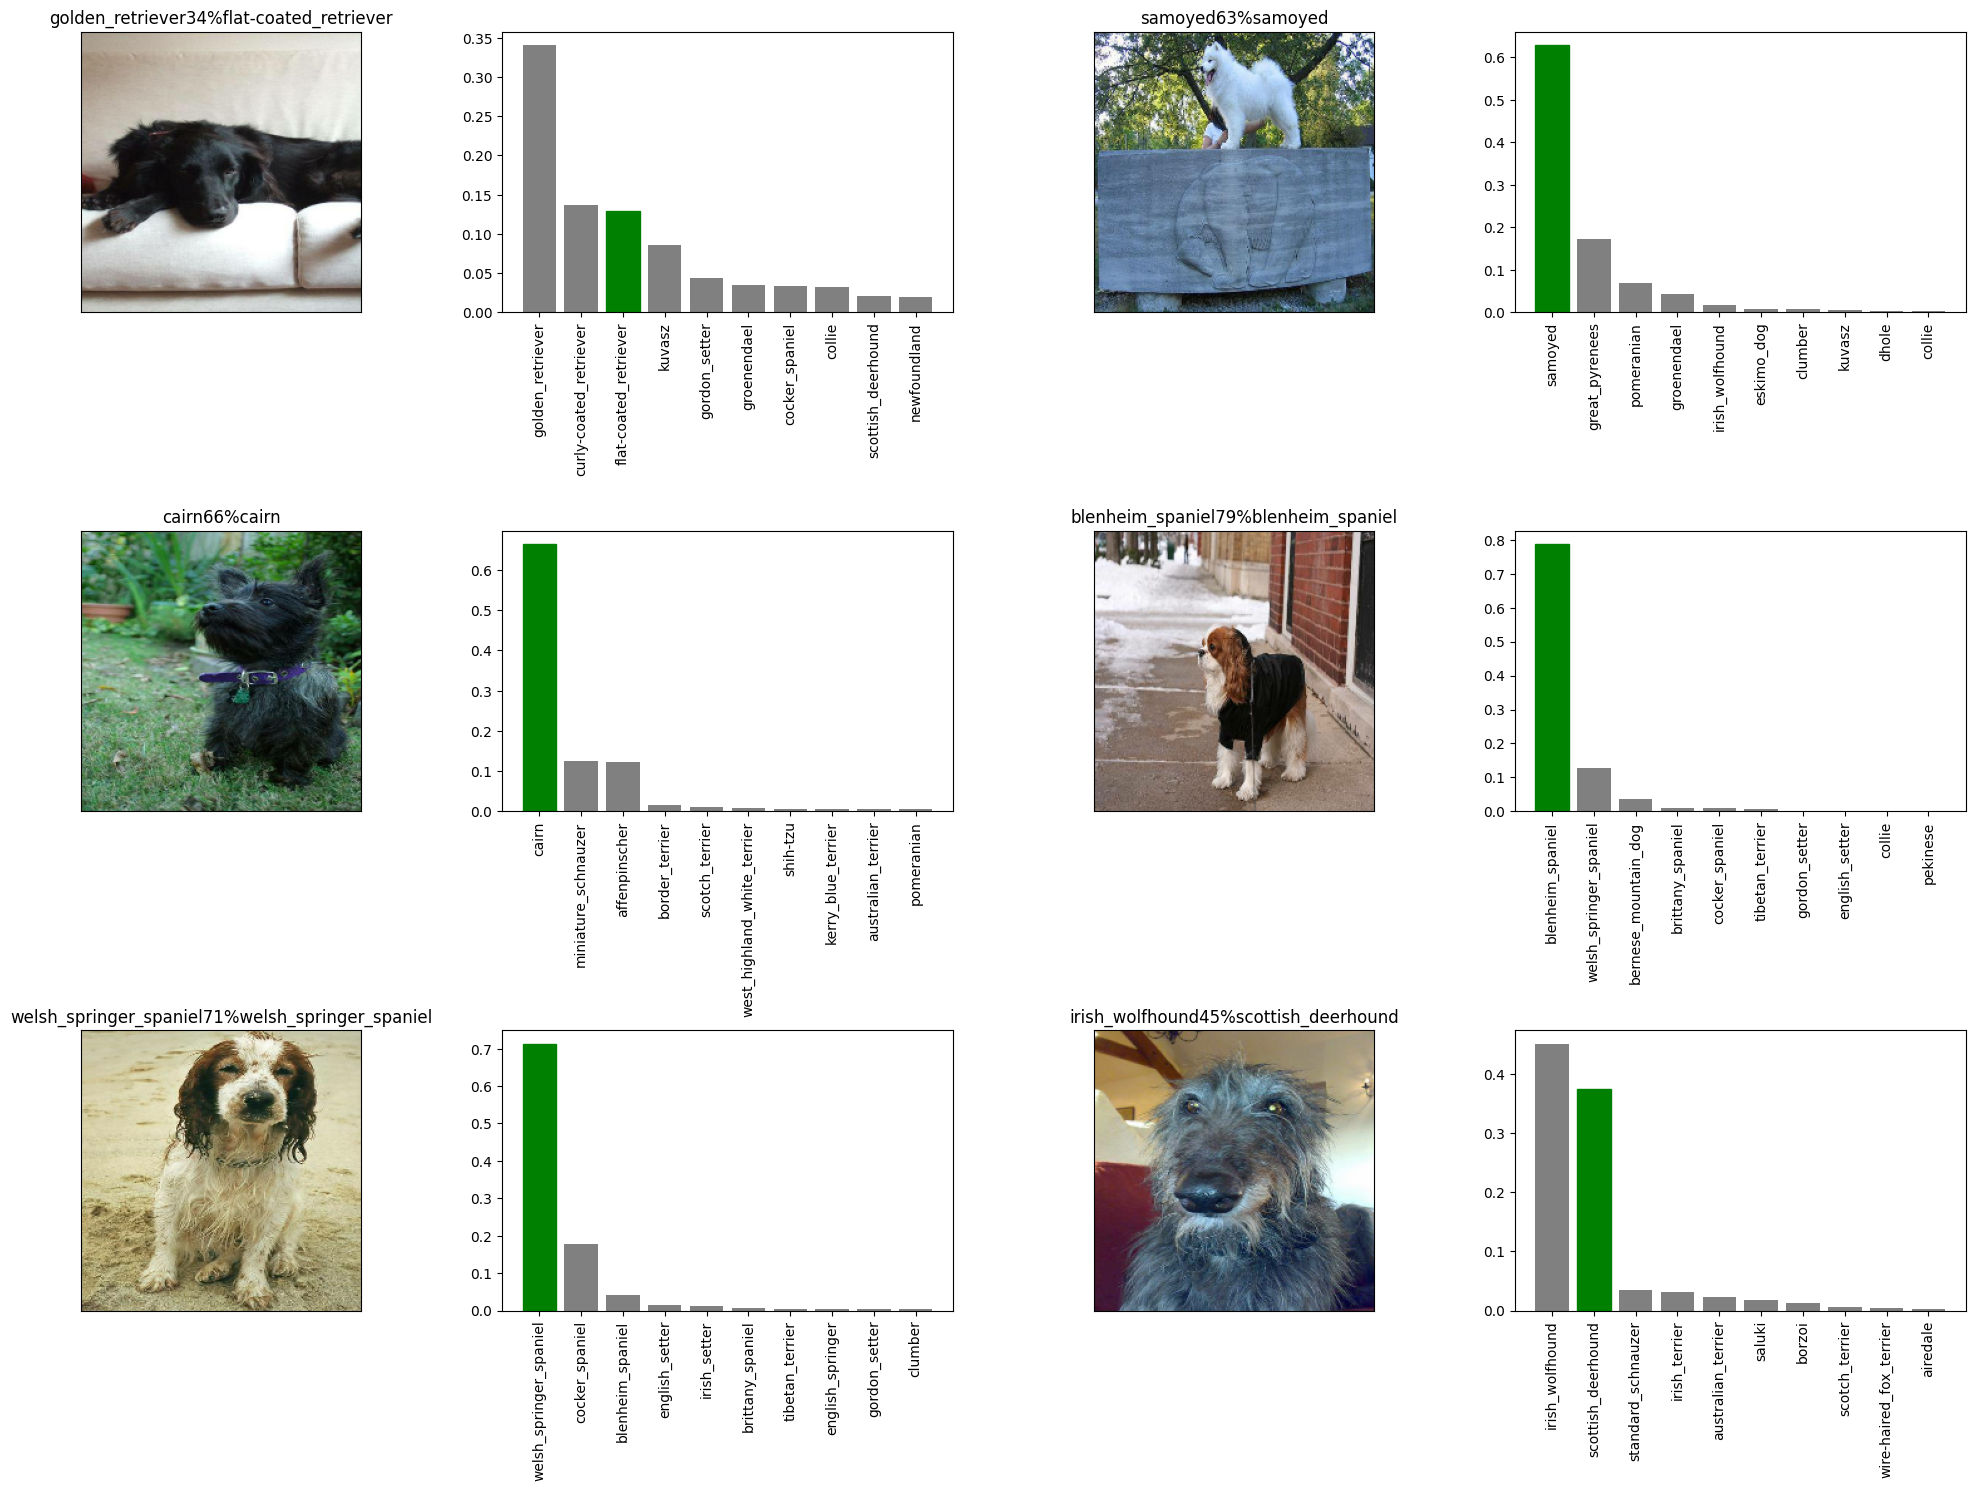

In [109]:
i_multiplier=20
num_rows=3
num_cols=2
num_images=num_cols*num_rows
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows,2*num_cols,2*i+1)
    plot_pred(prediction_prob=preds,labels=val_labels
             ,images=val_images,
             n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probs=preds,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# saving the model

In [116]:
def save_model(model,suffix=None):
    # create a model directory path name with current time
    modeldir=os.path.join("/kaggle/working/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path=modeldir+"-"+suffix+".h5"
    print(f"saving model to : {model_path}")
    model.save(model_path)
    return model_path

In [117]:
def load_model(model_path):
    print(f"loading the model from : {model_path}")
    model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
    return model


In [118]:
save_model(model,suffix="1000-images")

saving model to : /kaggle/working/models/20240227-17551709056559-1000-images.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/kaggle/working/models/20240227-17551709056559-1000-images.h5'

In [119]:
# load the model
load_model=load_model('/kaggle/working/models/20240227-17551709056559-1000-images.h5')

loading the model from : /kaggle/working/models/20240227-17551709056559-1000-images.h5


In [120]:
# evaluate the loaded model
model.evaluate(val_data)

7/7 [==============================] - 0s 50ms/step - loss: 1.2230 - accuracy: 0.6800


[1.2230252027511597, 0.6800000071525574]

In [121]:
load_model.evaluate(val_data)

7/7 [==============================] - 1s 47ms/step - loss: 1.2230 - accuracy: 0.6800


[1.2230252027511597, 0.6800000071525574]

# Training the big dog model

In [122]:
len(X),len(y)

(10222, 10222)

In [124]:
len(X_train)

800

In [125]:
# Create the data batch with full dataset
full_data=create_data_batches(X,y)


Creating Batches...


In [126]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [127]:
full_model=create_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [128]:
# callbacks
full_model_tensorboard=create_tensorboard_callback()

full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                          patience=3)

In [129]:
# fit the model
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 29s 76ms/step - loss: 1.3184 - accuracy: 0.6737
Epoch 2/100
320/320 [==============================] - 14s 45ms/step - loss: 0.3917 - accuracy: 0.8841
Epoch 3/100
320/320 [==============================] - 14s 45ms/step - loss: 0.2352 - accuracy: 0.9356
Epoch 4/100
320/320 [==============================] - 15s 46ms/step - loss: 0.1513 - accuracy: 0.9625
Epoch 5/100
320/320 [==============================] - 15s 46ms/step - loss: 0.1058 - accuracy: 0.9783
Epoch 6/100
320/320 [==============================] - 15s 46ms/step - loss: 0.0755 - accuracy: 0.9867
Epoch 7/100
320/320 [==============================] - 15s 45ms/step - loss: 0.0600 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 15s 45ms/step - loss: 0.0462 - accuracy: 0.9930
Epoch 9/100
320/320 [==============================] - 15s 45ms/step - loss: 0.0368 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 15s 45ms/step - l

In [130]:
save_model(full_model,suffix="full-image-model")

saving model to : /kaggle/working/models/20240227-18131709057612-full-image-model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/kaggle/working/models/20240227-18131709057612-full-image-model.h5'

In [139]:
## making predictionns on test dataset
test_path="/kaggle/input/dog-breed-identification/test/"
test_filenames=[test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg',
 '/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg',
 '/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg',
 '/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 '/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg']

In [140]:
len(test_filenames)

10357

In [141]:
test_data=create_data_batches(test_filenames,test_data=True)

creating test data betches...


In [142]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [143]:
test_preds=load_model.predict(test_data,verbose=1)

324/324 [==============================] - 28s 87ms/step


# prepairing test dataset predictions

To get the data in this format, we'll:

- Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
- Add data to the ID column by extracting the test image ID's from their filepaths.
- Add data (the prediction probabilites) to each of the dog breed columns.
- Export the DataFrame as a CSV to submit it to Kaggle.

In [144]:
preds_df=pd.DataFrame(columns=["id"]+list(Unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [148]:
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:10]
preds_df["id"]=test_ids

In [150]:
preds_df.head()

id affenpinscher afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa           NaN          NaN   
1  f7a32505c12649183c5991ecfa7d68b3           NaN          NaN   
2  bc6d50ffb4644feb34530aa58943e85b           NaN          NaN   
3  7cbc041e79135a572aad87904b5c9c57           NaN          NaN   
4  f3b603f10d6a344f0395fb46b242ff8e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [151]:
# ADD THE PREDICTION PROBABILITIES TO EACH DOG BREED COLUMN
preds_df[list(Unique_breeds)]=test_preds

In [153]:
preds_df

id  affenpinscher  afghan_hound  \
0      09e51e17e2b756ff2ace8a87bd1443fa   1.687909e-03      0.000057   
1      f7a32505c12649183c5991ecfa7d68b3   8.307239e-07      0.000003   
2      bc6d50ffb4644feb34530aa58943e85b   4.671338e-05      0.024589   
3      7cbc041e79135a572aad87904b5c9c57   5.582600e-04      0.000033   
4      f3b603f10d6a344f0395fb46b242ff8e   1.166188e-05      0.000004   
...                                 ...            ...           ...   
10352  d28a328d59d0b2d37fb3ae7ff0128451   1.374038e-04      0.000446   
10353  e60f6620bf8751538db9006d425f1b45   1.673311e-04      0.007614   
10354  54f6834b3819d6f0e9ff966070f35668   3.128372e-05      0.000056   
10355  0608afccc6d9b117730a2ffdb3314d18   1.127821e-03      0.041713   
10356  f661761277c257e1c35c48e72820b882   5.006478e-03      0.010508   

       african_hunting_dog  airedale  american_staffordshire_terrier  \
0             5.050136e-04  0.000310                        0.204530   
1             5.329192e-07  0.000002                        0.000004   
2             4.674426e-05  0.000684                        0.000545   
3             3.321151e-04  0.000211                        0.007860   
4             4.092186e-05  0.000021                        0.000031   
...                    ...       ...                             ...   
10352         8.379175e-04  0.000186                        0.000059   
10353         3.282535e-04  0.000001                        0.000290   
10354         2.126966e-03  0.000002                        0.000711   
10355         3.072431e-03  0.000440                        0.000144   
10356         7.711684e-05  0.000804                        0.000168   

       appenzeller  australian_terrier   basenji    basset  ...  toy_poodle  \
0         0.000651            0.000573  0.257604  0.000379  ...    0.000675   
1         0.000195            0.000001  0.000054  0.000036  ...    0.000007   
2         0.000159            0.000689  0.000152  0.000091  ...    0.000133   
3         0.000599            0.001702  0.002245  0.000207  ...    0.000386   
4         0.000010            0.000006  0.000045  0.000257  ...    0.000006   
...            ...                 ...       ...       ...  ...         ...   
10352     0.000072            0.000053  0.000150  0.000043  ...    0.002180   
10353     0.000280            0.000007  0.000083  0.003262  ...    0.003721   
10354     0.000006            0.000012  0.017054  0.000189  ...    0.000367   
10355     0.000661            0.000141  0.000237  0.000017  ...    0.010298   
10356     0.000241            0.003803  0.000062  0.001379  ...    0.000189   

        toy_terrier    vizsla  walker_hound  weimaraner  \
0      2.041841e-03  0.000056      0.000380    0.000053   
1      1.553951e-07  0.000040      0.000021    0.000006   
2      8.342563e-06  0.000027      0.000540    0.000099   
3      3.298540e-03  0.007460      0.000954    0.009197   
4      6.824838e-06  0.000015      0.000046    0.000009   
...             ...       ...           ...         ...   
10352  2.328664e-05  0.000007      0.000042    0.000039   
10353  2.299754e-06  0.000204      0.000377    0.000081   
10354  1.065649e-04  0.000209      0.000171    0.002751   
10355  2.590022e-05  0.001545      0.000251    0.000009   
10356  1.409763e-03  0.000165      0.000314    0.000276   

       welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0                    0.000028                 4.385963e-03  5.736985e-04   
1                    0.000005                 7.436994e-07  7.490449e-07   
2                    0.000143                 6.118863e-05  4.195642e-05   
3                    0.000030                 2.481271e-04  9.727922e-03   
4                    0.986993                 2.911616e-05  8.921579e-06   
...                       ...                          ...           ...   
10352                0.000101                 1.774452e-05  3.216793e-05   
10353                0.000100            

In [154]:
preds_df.to_csv("/kaggle/working/full_model_sub.csv")